# Sentiment analysis on emotone-ar dataset

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## Load the dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("emotone-ar-cicling2017/emotone_ar")

In [ ]:
# Check the number of samples
print(f"Total samples in the dataset: {len(ds)}")

Total samples in the dataset: 1


## getting Some info about data

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 10065
    })
})

## Splitting data into train and test split

In [ ]:
# Split the dataset into 80% training and 20% testing
train_test_split = ds['train'].train_test_split(test_size=0.2)

# Separate the training and testing datasets
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Check the number of samples in each set
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


Training samples: 8052
Testing samples: 2013


In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['tweet', 'label'],
     num_rows: 8052
 }),
 Dataset({
     features: ['tweet', 'label'],
     num_rows: 2013
 }))

In [ ]:
# View a sample from the dataset
train_dataset[0]

{'tweet': 'احا دبي قطعوا علي الاوليمبياد عشان يجيبيوا مؤتمر اعلان السوبر الاماراتي في مصر !!',
 'label': 6}

In [ ]:
train_dataset.features

{'tweet': Value(dtype='string', id=None),
 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}

In [ ]:
test_dataset.features

{'tweet': Value(dtype='string', id=None),
 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}

In [ ]:
ds['train'].features

{'tweet': Value(dtype='string', id=None),
 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}

In [ ]:
# Let's convert it to pandas for easy working
train_dataset.set_format(type='pandas')
df = ds[:]
df.head()

KeyError: "Invalid key: slice(None, None, None). Please first select a split. For example: `my_dataset_dictionary['train'][slice(None, None, None)]`. Available splits: ['train']"

<Axes: xlabel='label'>

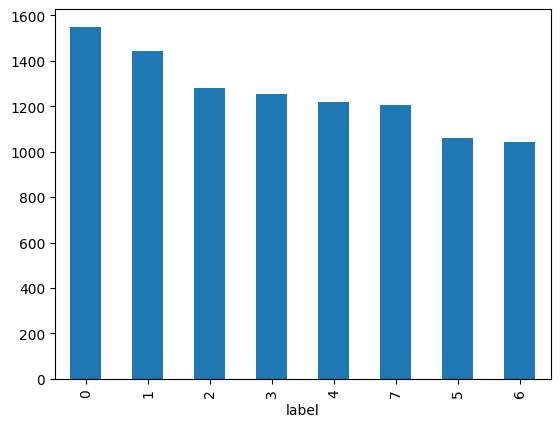

In [ ]:
# get values of each label
df['label'].value_counts().plot(kind='bar')

In [ ]:
# get labels into label names
ds['train'].features['label'].names

['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [ ]:
# mapping labels into label names in df
df['label_name'] = df['label'].map(lambda x: ds['train'].features['label'].int2str(x))
df.head()

,tweet,label,label_name
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,0,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,1,anger
2,كتنا نيله ف حظنا الهباب xD,3,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,2,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,0,none


<Axes: xlabel='label_name'>

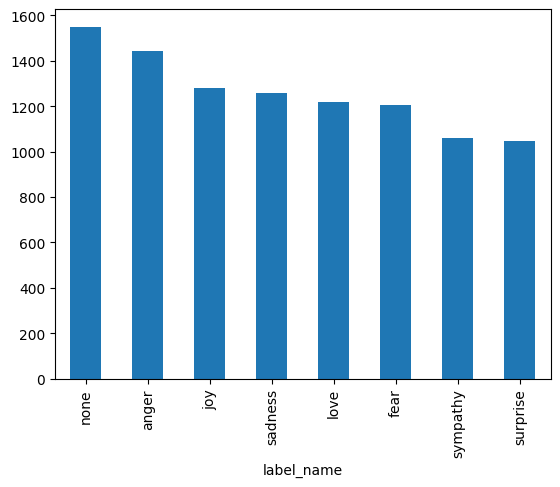

In [ ]:
# get values of each label
df['label_name'].value_counts().plot(kind='bar')

## get length of `98%` of tweets

<Axes: ylabel='Frequency'>

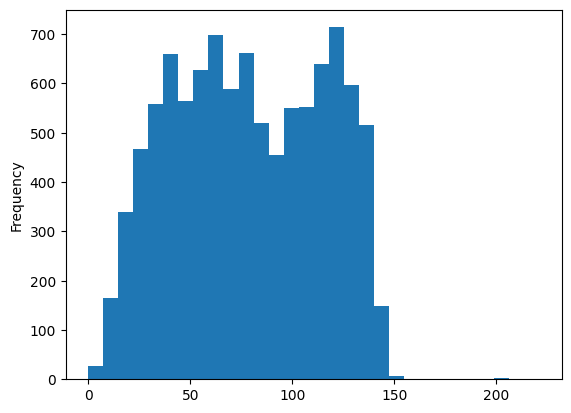

In [ ]:
# get distribution of lengths of tweetrs in dataset
df['tweet'].str.len().plot(kind='hist', bins=30)

In [ ]:
# get length of tweets which have 98% of data
max_length_98th_percentile = int(df['tweet'].str.len().quantile(0.98))
max_length_98th_percentile

139

## Testing LLM model as pipeline

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert/distilbert-base-multilingual-cased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Check the task name and the defualt model
classifier.task, classifier.model

('sentiment-analysis',
 DistilBertForSequenceClassification(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(119547, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
          

In [ ]:
train_dataset['tweet'][0]

'مريم مدحت لو مرعبتنيش قبل اي نتيجه ليها تتحرق. بتحسسني ان مفيش امل هتعيد السنه يا اما هيطلعوها ب6 مواد و فالاخر هييه نجحت يا شيخه منك لله????????'

In [ ]:
# List of exmaples
results = classifier(train_dataset['tweet'][0])
results

[{'label': 'LABEL_0', 'score': 0.5330026149749756}]

## Tokenize both train and test datasets

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from huggingface_hub import notebook_login

In [ ]:
# Login to Hugging Face Hub
notebook_login()

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

In [ ]:
# Let's examine the tokenizer
text = 'Tokenization is the core task of NLP'
encoded_text = tokenizer(text, return_tensors='pt')
print(encoded_text)

{'input_ids': tensor([[  101, 11469, 11062, 19980, 10124, 10105, 27362, 37758, 10108, 81130,
         11127,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
# To get the tokens itself
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0], skip_special_tokens=False)
print(tokens)

['[CLS]', 'To', '##ken', '##ization', 'is', 'the', 'core', 'task', 'of', 'NL', '##P', '[SEP]']


In [ ]:
# To return back to the original text
regen_text = tokenizer.convert_tokens_to_string(tokens)
print(regen_text)

[CLS] Tokenization is the core task of NLP [SEP]


In [ ]:
# We can check the vocab. size and the max-length of context window
print(f'The vocab size of DistillBert Model is: {tokenizer.vocab_size}')
print(f'The context window of DistillBert Model is: {tokenizer.model_max_length}')


The vocab size of DistillBert Model is: 119547
The context window of DistillBert Model is: 512


In [ ]:
# tokenize the whole dataset
def tokenize_fn(batch):
  # Padding the short sentences and truncate the long sentences
  return tokenizer(batch['tweet'], padding=True, truncation=True, max_length=512, return_tensors='pt')

In [ ]:
# Apply the above function of tokenization to the whole dataset
train_data_encoded = train_dataset.map(tokenize_fn, batched=True, batch_size=None)
test_data_encoded = test_dataset.map(tokenize_fn, batched=True, batch_size=None)
train_data_encoded, test_data_encoded


(Dataset({
     features: ['tweet', 'label', 'input_ids', 'attention_mask'],
     num_rows: 8052
 }),
 Dataset({
     features: ['tweet', 'label', 'input_ids', 'attention_mask'],
     num_rows: 2013
 }))

## Extract hidden states from model

In [ ]:
import torch

# Check for GPU availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the model
model_ckpt = "distilbert-base-multilingual-cased"
model = AutoModel.from_pretrained(model_ckpt)
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
# Let's combine that in function
def extract_hidden_states_fn(batch):

  # Place the model input to the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract the last hidden states
  with torch.inference_mode():
    last_hidden_state = model(**inputs).last_hidden_state

  # Get only the vector of the first token [CLS], and convert back to cpu and numpy
  return {'hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

# Convert the tokenized numerical data (input_ids, attention_mask, label) to tensors
train_data_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# Apply the above function using the magic function (map) on the tokenized data
train_data_hidden = train_data_encoded.map(extract_hidden_states_fn, batched=True, batch_size=1000)
test_data_hidden = test_data_encoded.map(extract_hidden_states_fn, batched=True, batch_size=1000)
train_data_hidden, test_data_hidden

Map:   0%|          | 0/8052 [00:00<?, ? examples/s]

Map:   0%|          | 0/2013 [00:00<?, ? examples/s]

(Dataset({
     features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
     num_rows: 8052
 }),
 Dataset({
     features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
     num_rows: 2013
 }))

## Load the model for finetune


In [ ]:
# Load the model
model_ckpt = "distilbert-base-multilingual-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=8)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Making metrics function

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Define metrics calculation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
    }

## Training the model

In [ ]:
# Prepare the training arguments
batch_size = 32
logging_steps = len(train_data_encoded) // batch_size

# checkpoint name
model_chkpt_dir = f'{model_ckpt}-finetuned'

# Define some training arguments
training_args = TrainingArguments(output_dir=model_chkpt_dir,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='info')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Initialize the Trainer API
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_data_encoded,
                  eval_dataset=test_data_encoded,
                  tokenizer=tokenizer)

# Start Training
trainer.train();

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,052
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2,520
  Number of trainable parameters = 135,330,824


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.002600,1.041651,0.640835,0.632148
2,0.842200,1.035466,0.650770,0.642461
3,0.711400,1.061107,0.636364,0.634227
4,0.570900,1.067238,0.669151,0.666504
5,0.459000,1.116710,0.673125,0.669339
6,0.369400,1.170926,0.663686,0.667232
7,0.297500,1.209395,0.671634,0.669947
8,0.240200,1.277717,0.664183,0.663335
9,0.209000,1.299736,0.669151,0.668496
10,0.179200,1.309892,0.663189,0.664731


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2013
  Batch size = 32
Saving model checkpoint to distilbert-base-multilingual-cased-finetuned/checkpoint-500
Configuration saved in distilbert-base-multilingual-cased-finetuned/checkpoint-500/config.json
Model weights saved in distilbert-base-multilingual-cased-finetuned/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert-base-multilingual-cased-finetuned/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-finetuned/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-finetuned/tokenizer_config.json
Special tokens file saved in distilbert-base-mult

## Testing the model

In [ ]:
# testing the model
preds_output = trainer.predict(test_data_encoded)
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2013
  Batch size = 32


{'test_loss': 1.309892177581787,
 'test_accuracy': 0.6631892697466468,
 'test_f1': 0.6647306353156406,
 'test_runtime': 7.6849,
 'test_samples_per_second': 261.942,
 'test_steps_per_second': 8.198}

In [ ]:
import numpy as np

# get preds
preds = np.argmax(preds_output.predictions, axis=1)
preds

array([3, 3, 1, ..., 5, 2, 0])

<Axes: >

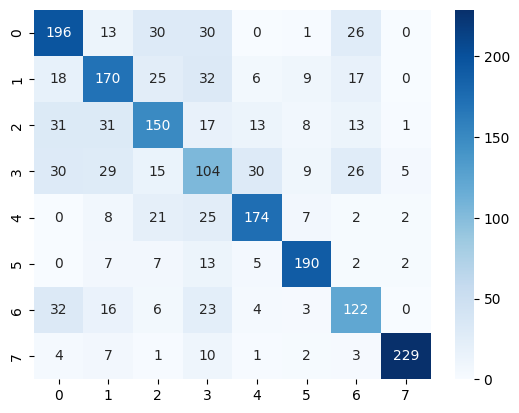

In [ ]:
# plotting cond matrics for preds
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data_encoded['label'], preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


## Pushing model onto hub


In [ ]:
# push model on hub
trainer.push_to_hub(commit_message='Training completed')

Saving model checkpoint to distilbert-base-multilingual-cased-finetuned
Configuration saved in distilbert-base-multilingual-cased-finetuned/config.json
Model weights saved in distilbert-base-multilingual-cased-finetuned/model.safetensors
tokenizer config file saved in distilbert-base-multilingual-cased-finetuned/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-finetuned/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.6631892697466468}, {'name': 'F1', 'type': 'f1', 'value': 0.6647306353156406}]}


model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1726937676.9929f3acd884.768.4:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/0marr/distilbert-base-multilingual-cased-finetuned/commit/01a58513fabb45dbbf8a142cdbfd49921757c652', commit_message='Training completed', commit_description='', oid='01a58513fabb45dbbf8a142cdbfd49921757c652', pr_url=None, pr_revision=None, pr_num=None)